## MovieLens Analysis
### By: Carter Carlson

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import scipy
import matplotlib.pyplot as plt

movies = pd.read_csv('../Data/movies.csv')
ratings = pd.read_csv('../Data/ratings.csv')

### Optimizing table size

In [2]:
# Original memory usage of dataset
print('Ratings: original data\n')
print(ratings.info(memory_usage='deep'))

## Convert ratings to a 1-10 scale and finish cleaning table
ratings['rating'] *= 2
ratings['rating'] = ratings['rating'].astype(np.int8)
ratings['movieId'] = ratings['movieId'].astype(np.int32)
ratings = ratings[['rating', 'movieId']]

print('\n\nRatings: optimized data\n')
print(ratings.info(memory_usage='deep'))

Ratings: original data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 610.4 MB
None


Ratings: optimized data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 2 columns):
rating     int8
movieId    int32
dtypes: int32(1), int8(1)
memory usage: 95.4 MB
None


Our optimized dataset takes up 80% less memory!



---


### Extracting movie release year from title

1. Remove movies without a year in the title

In [3]:
# List of movies that don't have a year in their name
movies_to_remove = {movies['movieId'][i]:movies['title'][i]
                    for i in range(len(movies))
                    if not ('18' in movies['title'][i]
                    or '19' in movies['title'][i]
                    or '20' in movies['title'][i])}

# Remove said movies from our datasets
ratings = ratings.loc[~ratings['movieId'].isin(movies_to_remove)].reset_index(drop=True)
movies = movies.loc[~movies['movieId'].isin(movies_to_remove)].reset_index(drop=True)

2. Label the movies as 'Old', 'Medium', or 'New'

In [4]:
# Function to pull year from the end of the movie title
def extract_year(title):
    if title.find('(') < 0:
        return int(title[:4])

    return extract_year(title[title.find('(')+1:])


# Remove any extra spaces
movies['title'] = movies['title'].str.strip()

movies['year'] = [extract_year(movie) for movie in movies['title']]

movies['age'] = 'Old'
movies.loc[movies['year'] >= 1970, 'age'] = 'Medium'
movies.loc[movies['year'] >= 1990, 'age'] = 'New'

---
### Data Exploration
1. Movie rating stats

In [5]:
ratings_count = ratings.groupby('movieId').count()
movies_count = movies.groupby('movieId').count()
ratings_count.reset_index(inplace=True)
movies_count = movies_count.reset_index()[['movieId', 'title']]

num_movies = ratings_count.count()[0]
under_50_ratings = ratings_count.loc[ratings_count['rating'] < 50].count()[0]
avg_rating = int(ratings_count['rating'].mean())
std_rating = int(ratings_count['rating'].std())


print('Movies reviewed:  {}'.format(num_movies))
print('Movies with less than 50 reviews:  {}'.format(under_50_ratings))
print('Average number of ratings for a movie:  {}'.format(avg_rating))
print('Standard deviation of ratings:  {}'.format(std_rating))

Movies reviewed:  26725
Movies with less than 50 reviews:  16202
Average number of ratings for a movie:  748
Standard deviation of ratings:  3086


It would be interesting to see if the movies with fewer ratings will skew the ML results.  For example there are over 26,000 different movies, and over 60% of movies have less than 50 reviews, even though the average number of reviews for a movie is over 700.  That explains the high standard deviation.

2. Movie rating distribution

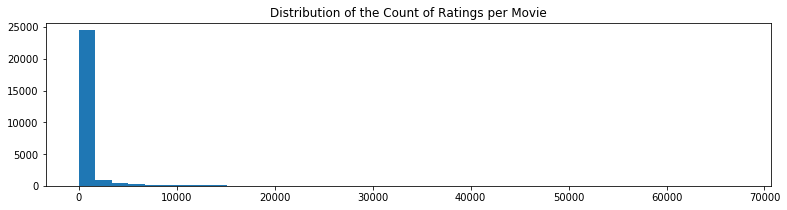

In [6]:
plt.figure(figsize=(13, 3))
plt.hist(ratings_count['rating'], bins=40)
plt.title('Distribution of the Count of Ratings per Movie')
plt.show()

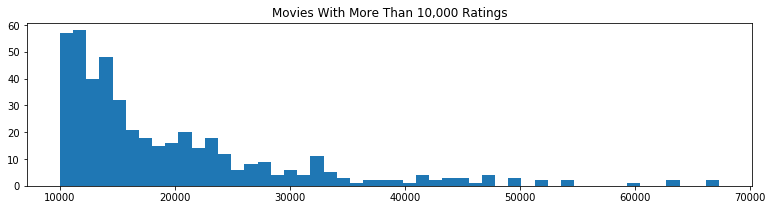

In [7]:
plt.figure(figsize=(13, 3))
plt.hist(ratings_count.loc[ratings_count['rating'] > 10000]['rating'], bins=50)
plt.title('Movies With More Than 10,000 Ratings')
plt.show()

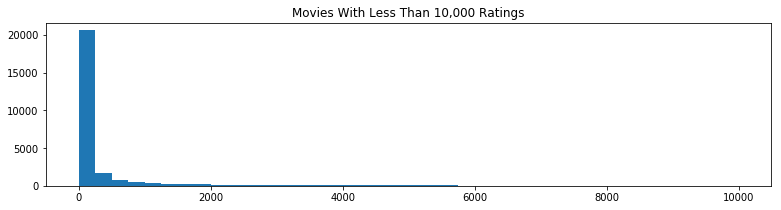

In [8]:
plt.figure(figsize=(13, 3))
plt.hist(ratings_count.loc[ratings_count['rating'] < 10000]['rating'], bins=40)
plt.title('Movies With Less Than 10,000 Ratings')
plt.show()

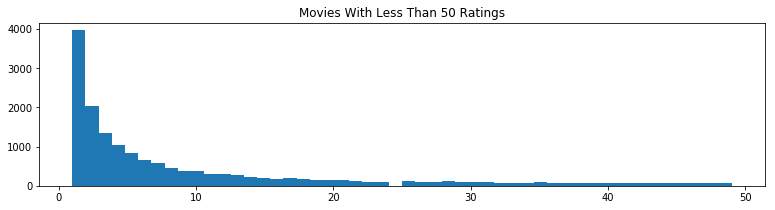

In [9]:
plt.figure(figsize=(13, 3))
plt.hist(ratings_count.loc[ratings_count['rating'] < 50]['rating'], bins=50)
plt.title('Movies With Less Than 50 Ratings')
plt.show()

3. Unique movies

In [10]:
print('Count of unique "movieId" in ratings: {}'.format(ratings_count.count().values[0]))
print('Count of unique "movieId" in movies: {}'.format(movies_count.count().values[0]))

Count of unique "movieId" in ratings: 26725
Count of unique "movieId" in movies: 27259


The next step is to find movies that are in one table and not the other, and see if they're outliers we can remove.

#### Prediction: ML with the number of ratings may be more accurate than using Genre or Age.
My theory is that movies with more reviews will have a higher rating. Generally, people are more likely to watch a movie if a friend recommended it, and less likely to watch a movie if a friend didn't like it.  Also, movies with a large budget and top producers/actors will usually 
have a higher video quality than a movie created by first-time producers/actors.